# 1. Load Data and Libraries

In [1]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

In [2]:
# train test data load
train_df = pd.read_csv('data/train.csv', encoding = 'cp949')
test_df = pd.read_csv('data/test.csv', encoding = 'cp949')

In [3]:
train_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [4]:
# renaming columns
train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   num              122400 non-null  int64  
 1   datetime         122400 non-null  object 
 2   target           122400 non-null  float64
 3   temperature      122400 non-null  float64
 4   windspeed        122400 non-null  float64
 5   humidity         122400 non-null  float64
 6   precipitation    122400 non-null  float64
 7   insolation       122400 non-null  float64
 8   nelec_cool_flag  122400 non-null  float64
 9   solar_flag       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [6]:
train_df.describe()

,num,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


# 2. Exploratory Data Analysis

In [7]:
eda_df = train_df.copy()

In [8]:
# 시간 변수를 효율적으로 다루기 위해 padnas의 datetime으로 변환
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

### Target 분포 확인 

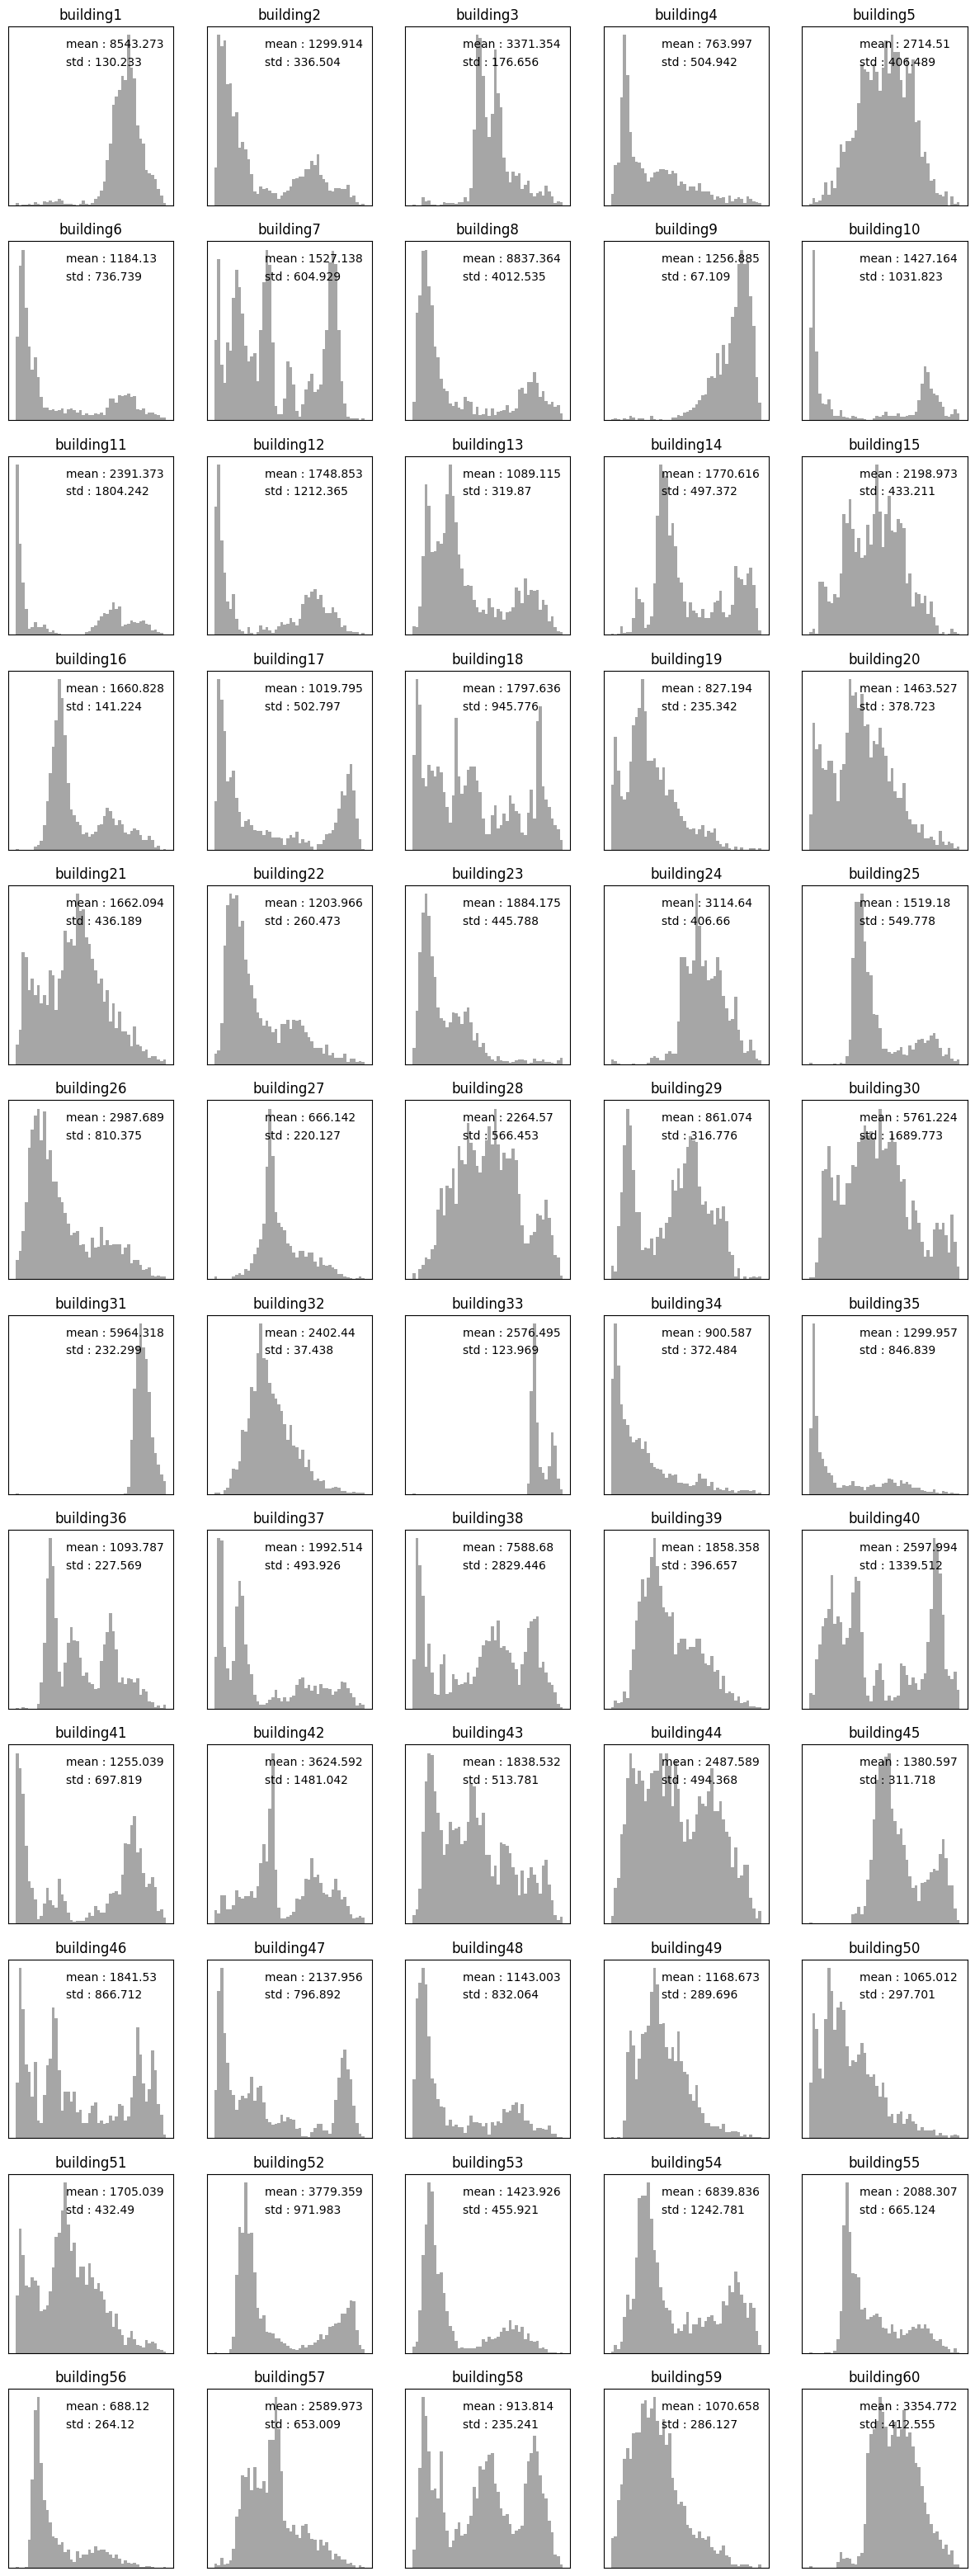

In [9]:

fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = eda_df.loc[eda_df.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)

### 전체 상관관계

<Axes: >

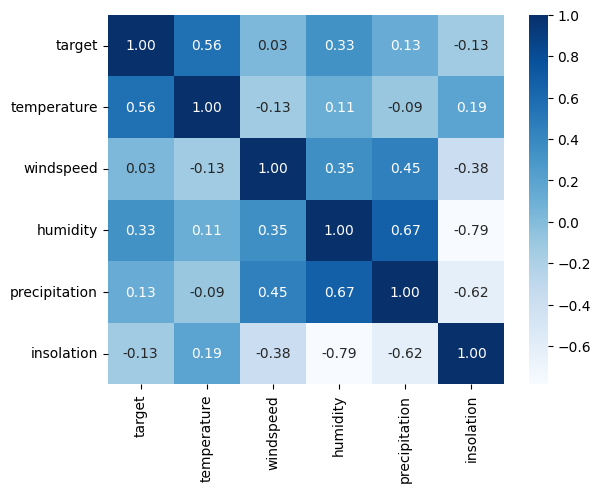

In [18]:
sns.heatmap(eda_df.groupby(['date'])[['target','temperature','windspeed','humidity','precipitation','insolation']].mean().corr(), cmap = 'Blues', annot = True, fmt = '.2f')

### 각 건물 별 전력 사용량과 Feature의 상관관계

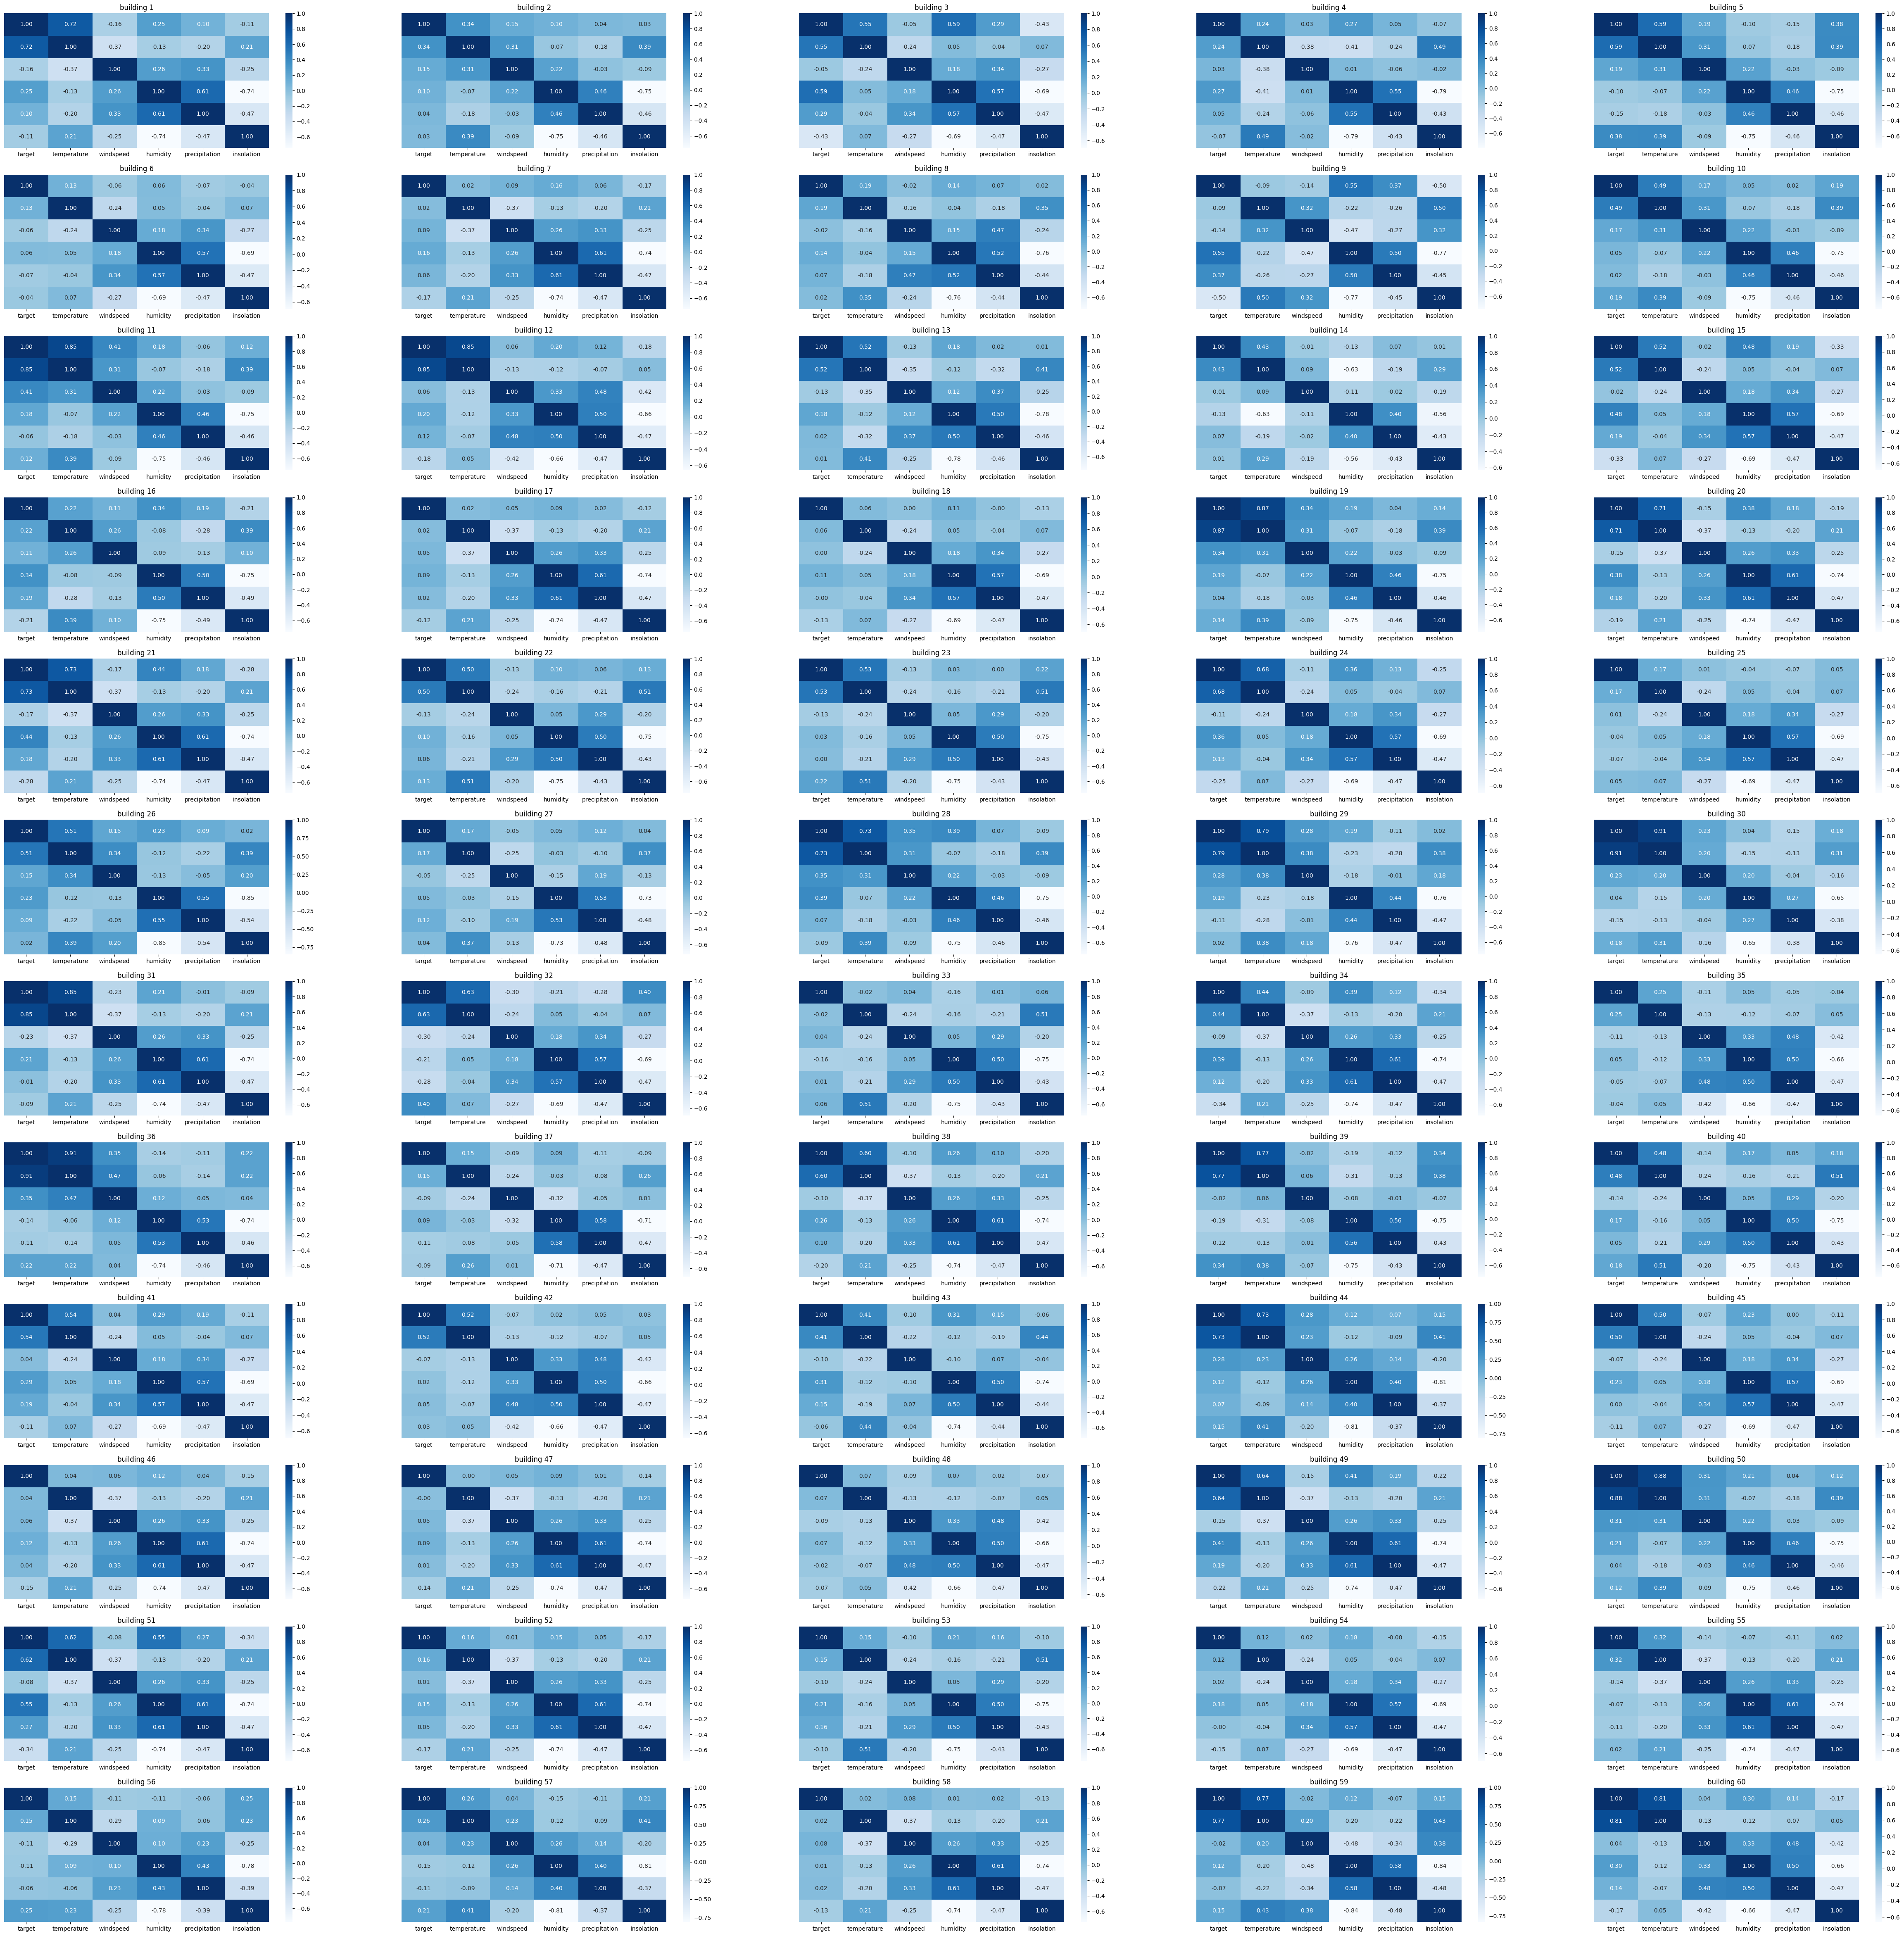

In [10]:

fig = plt.figure(figsize = (60, 60))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    plt.subplot(12, 5, num)
    sns.heatmap(df.groupby(['date'])[['target','temperature','windspeed','humidity','precipitation','insolation']].mean().corr(), cmap = 'Blues', annot = True, fmt = '.2f')
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

### 용도 분류를 위한 요일 및 사용 시간 별 전력 사용량

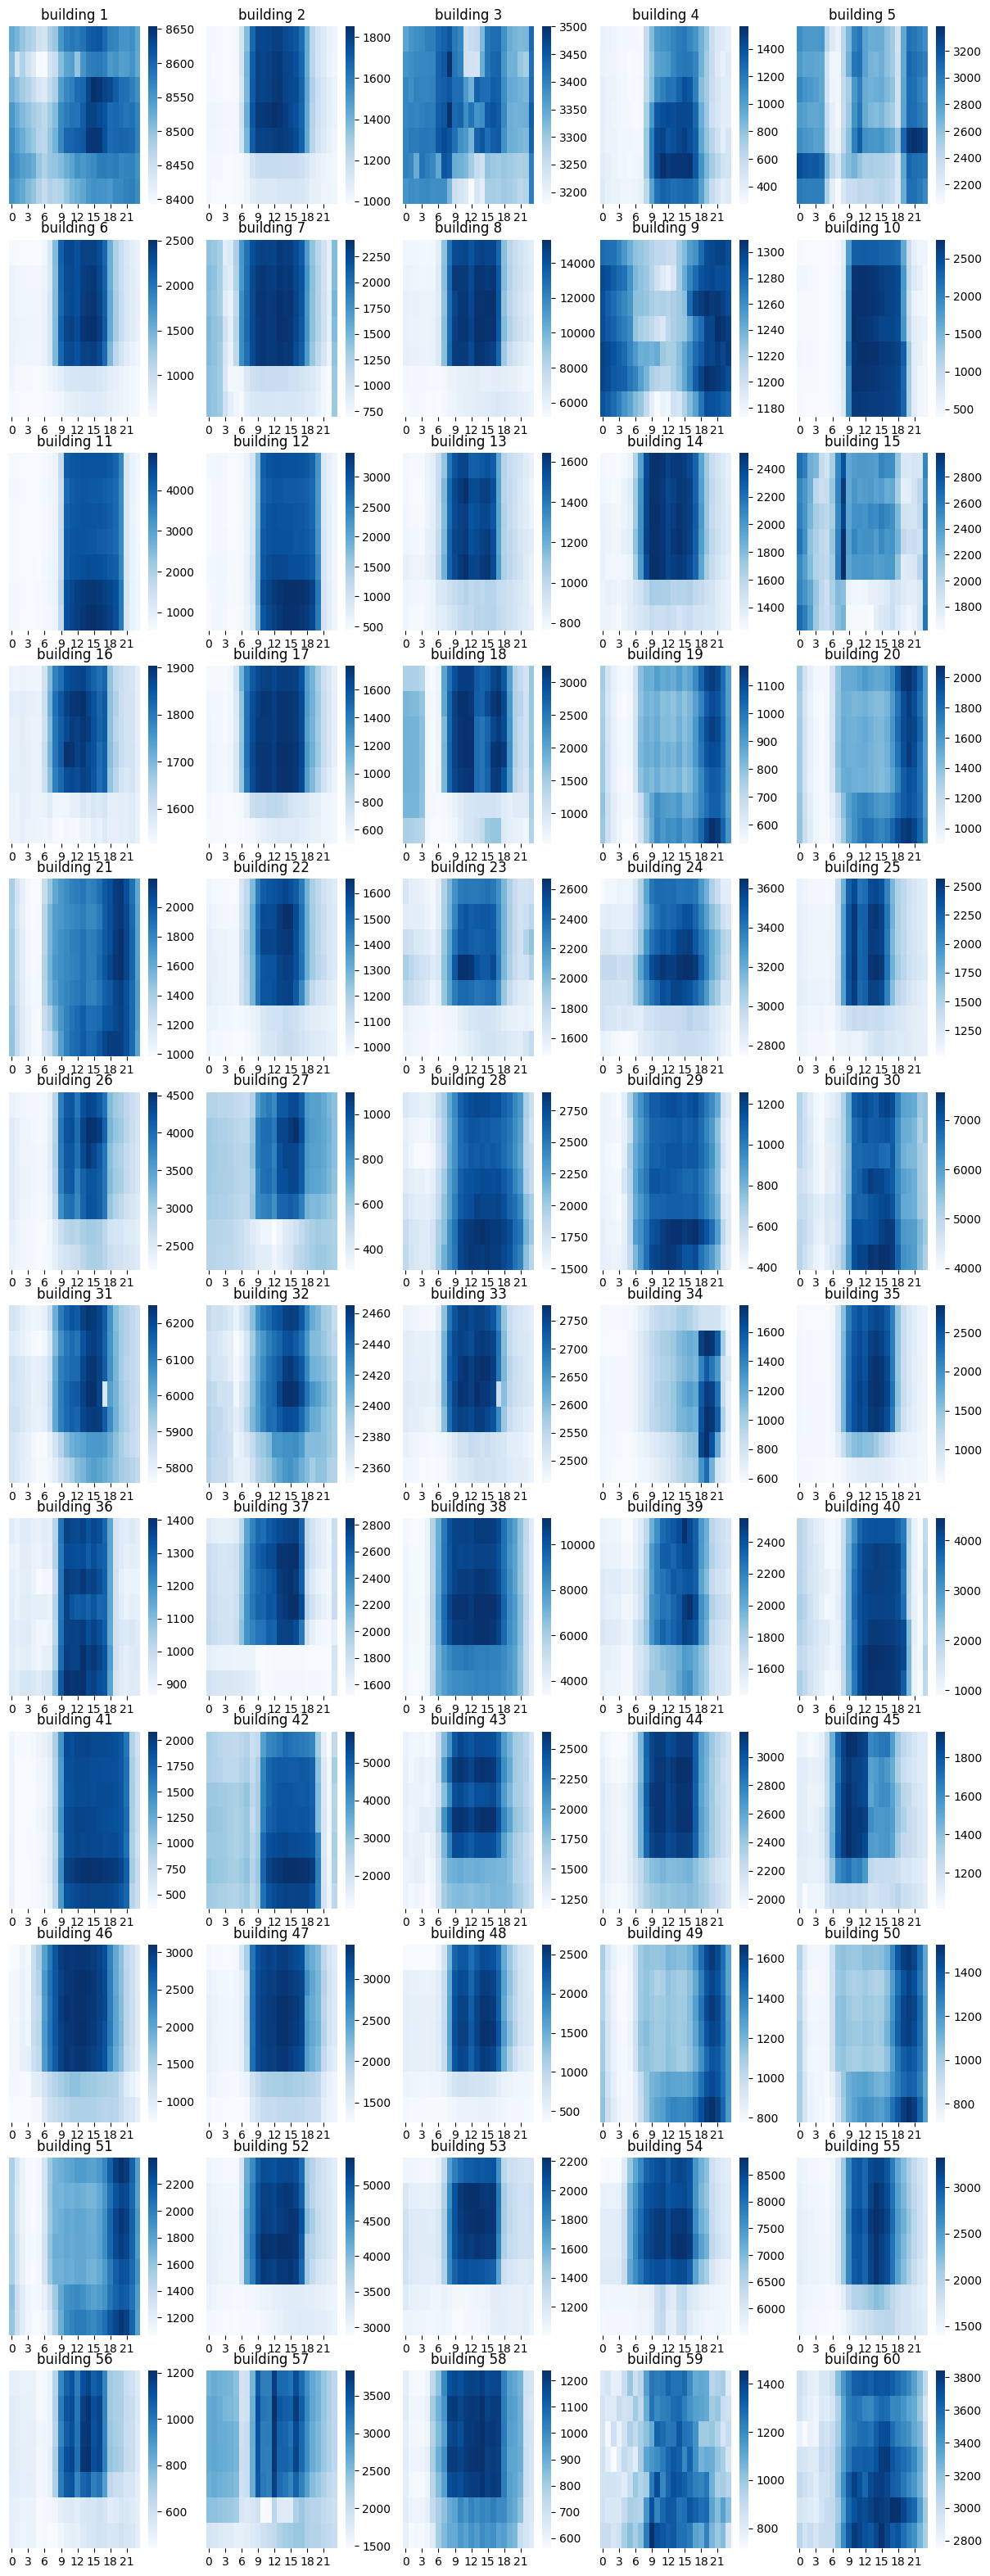

In [11]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(df, cmap = 'Blues')
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

## 군집화

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# 각 건물별 corrilation 정보 추출 
corr_list = []
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    corr_list.append(df.groupby(['date'])[['target','temperature','windspeed','humidity','precipitation','insolation']].mean().corr()['target'].iloc[1:].values)
corr = np.array(corr_list)

# 3시간 단위 전력 수요량
eda_df['hour_by3'] = eda_df['datetime'].apply(lambda x: str(x.hour//3*3).zfill(2))
agg_cl = eda_df.groupby(['num', 'hour_by3', 'day'])['target'].median().reset_index()
agg_cl['R'] = agg_cl.groupby('num')['target'].apply(lambda x: x/x.max())
dt_cl = agg_cl.pivot_table(index='num', columns=['day', 'hour_by3'], values='R')



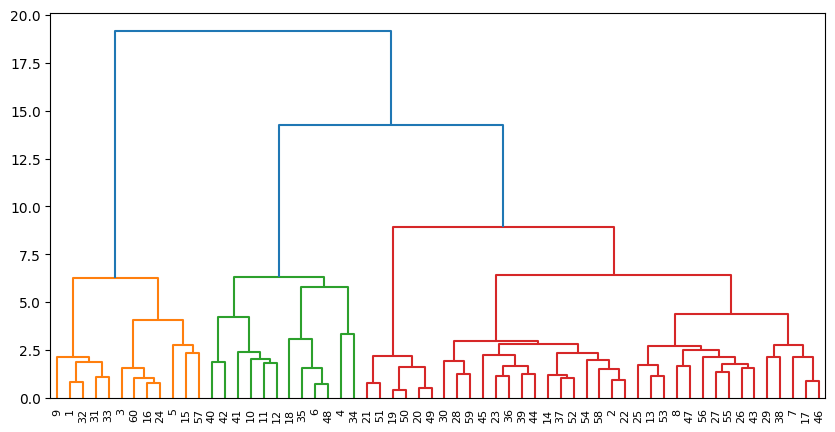

In [11]:
# 3시간 단위 전력수요량  + 건물별 corrilation 정보로 cluster

fig = plt.figure(figsize = (10, 5))
dist_building = pdist(np.concatenate([dt_cl.values, corr,eda_df.groupby(['num'])[['solar_flag',"nelec_cool_flag"]].mean().values], axis=1))
hc_building = linkage(dist_building, method='ward')
dendrogram(hc_building, labels=dt_cl.index, leaf_rotation=90, leaf_font_size=8)
plt.show()

In [12]:
#cluster 결과
from scipy.cluster.hierarchy import fcluster
clusters =  pd.DataFrame({'num': range(1, 61), 'cluster':  fcluster(hc_building, t=5, criterion='maxclust')})

In [13]:
#cluster 결과 merge
eda_df = pd.merge(eda_df, clusters, on='num', how='left')

### Cluster 별 전력 사용량 시각화

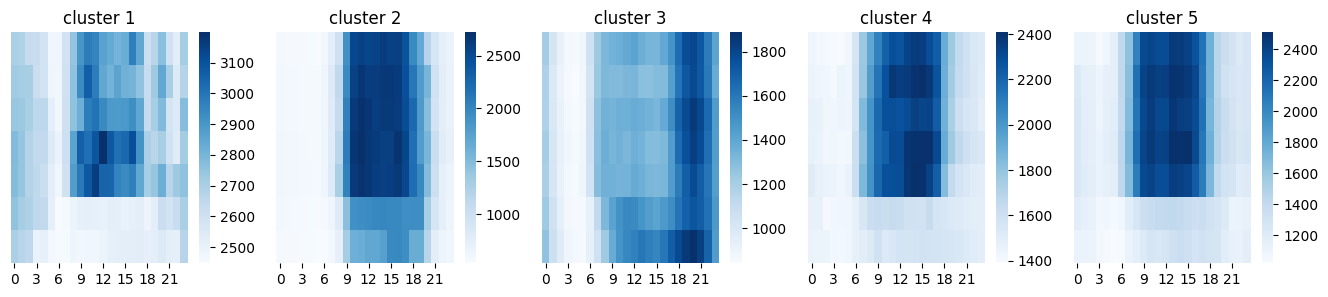

In [15]:
fig = plt.figure(figsize = (20, 3))
for c in range(1,6):
    temp = eda_df[eda_df.cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 6, c+1)
    sns.heatmap(temp, cmap = 'Blues')
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

### Cluster 상관관계

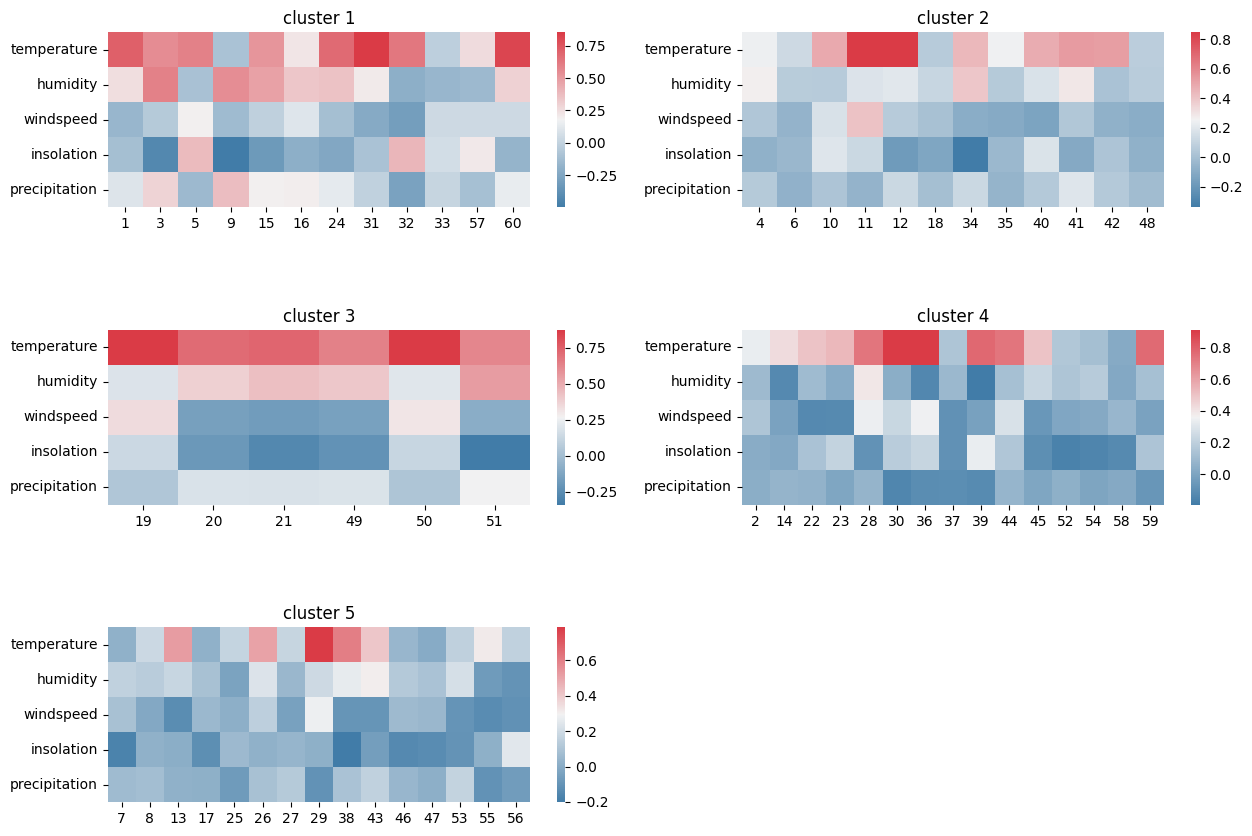

In [16]:
plt.figure(figsize=(15,10))
for i in range(1,6):
    a = {}
    ddt = eda_df[eda_df.cluster == i].groupby(['num','date'])[['temperature','humidity','windspeed','insolation','precipitation','target']].mean()
    for j in ddt.index.get_level_values(0).unique():
        a[j] = ddt.loc[j].corr()['target'] 
    b = pd.DataFrame(a)
    plt.subplot(3,2,i)
    sns.heatmap(b[:-1],cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'cluster {i}')


# 3. Data Preprocessing & Feature Engineering & Modeling

In [18]:
## target selection
target = ['date',"target",'num','cluster','temperature', 'windspeed', 'humidity',
       'precipitation', 'insolation', 'hour',
       'weekday', 'day', 'month']
train = eda_df[target].copy()

In [19]:
#train test 데이터 생성 

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer
from xgboost import XGBRegressor
import tqdm

y_trains = []
y_valids = []
x_trains = []
x_valids = []
for i in tqdm.tqdm(range(1,61)): 
    y = train.loc[train.num == i, 'target']
    x = train.loc[train.num == i].iloc[:, 2:]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    y_trains.append(y_train)
    y_valids.append(y_valid)
    x_trains.append(x_train)
    x_valids.append(x_valid)

y_trains = pd.concat(y_trains)
y_valids = pd.concat(y_valids)
x_trains = pd.concat(x_trains)
x_valids = pd.concat(x_valids)

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

100%|██████████| 60/60 [00:00<00:00, 240.00it/s]


In [20]:
#전체 데이터를 하나의 모델로 학습
xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
            gpu_id=-1, importance_type='gain', interaction_constraints='',
            learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
            min_child_weight=6, monotone_constraints='()',
            n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
            subsample=0.9, tree_method='exact', validate_parameters=1,
            verbosity=None)

xgb_reg.fit(x_trains.iloc[:,2:], y_trains, eval_set=[(x_trains.iloc[:,2:], y_trains), (x_valids.iloc[:,2:], y_valids)],
        early_stopping_rounds=300,
    verbose=False)

pred = xgb_reg.predict(x_valids.iloc[:,2:])
pred = pd.Series(pred)
pred.index = y_valids.index
print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valids, pred)))

best iterations: 527
SMAPE : 26.15419430897391


In [20]:
# cluster 별로 모델을 생성해서 학습
xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
            gpu_id=-1, importance_type='gain', interaction_constraints='',
            learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
            min_child_weight=6, monotone_constraints='()',
            n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
            subsample=0.9, tree_method='exact', validate_parameters=1,
            verbosity=None)
ys = []
preds = []
c_models = {}
for i in tqdm.tqdm(range(1,6)):
    x_train = x_trains[x_trains.cluster == i]
    y_train = y_trains[x_trains.cluster == i]
    x_valid = x_valids[x_valids.cluster == i]
    y_valid = y_valids[x_valids.cluster == i]

    xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
            gpu_id=-1, importance_type='gain', interaction_constraints='',
            learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
            min_child_weight=6, monotone_constraints='()',
            n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
            subsample=0.9, tree_method='exact', validate_parameters=1,
            verbosity=None)
    
    xgb_reg.fit(x_train.iloc[:,2:], y_train, eval_set=[(x_train.iloc[:,2:], y_train), (x_valid.iloc[:,2:], y_valid)],
            early_stopping_rounds=300,
        verbose=False)
    pred = xgb_reg.predict(x_valid.iloc[:,2:])
    pred = pd.Series(pred)
    pred.index = y_valid.index
    c_models[i] = xgb_reg
    ys.append(y_valid)
    preds.append(pred)

ys = pd.concat(ys)
preds = pd.concat(preds)
print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(ys, preds)))

100%|██████████| 5/5 [00:38<00:00,  7.61s/it]

best iterations: 391
SMAPE : 21.350850117768136


In [ ]:
# 건물별 모델을 생성해서 학습
xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
            gpu_id=-1, importance_type='gain', interaction_constraints='',
            learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
            min_child_weight=6, monotone_constraints='()',
            n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
            subsample=0.9, tree_method='exact', validate_parameters=1,
            verbosity=None)
ys_d = []
preds_d = []
d_models = {}
for i in tqdm.tqdm(range(1,61)):
    x_train = x_trains[x_trains.num == i]
    y_train = y_trains[x_trains.num == i]
    x_valid = x_valids[x_valids.num == i]
    y_valid = y_valids[x_valids.num == i]

    xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
            gpu_id=-1, importance_type='gain', interaction_constraints='',
            learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
            min_child_weight=6, monotone_constraints='()',
            n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
            subsample=0.9, tree_method='exact', validate_parameters=1,
            verbosity=None)
    
    xgb_reg.fit(x_train.iloc[:,2:], y_train, eval_set=[(x_train.iloc[:,2:], y_train), (x_valid.iloc[:,2:], y_valid)],
            early_stopping_rounds=300,
        verbose=False)
    pred = xgb_reg.predict(x_valid.iloc[:,2:])
    pred = pd.Series(pred)
    pred.index = y_valid.index
    d_models[i] = xgb_reg
    ys_d.append(y_valid)
    preds_d.append(pred)

ys_d = pd.concat(ys_d)
preds_d = pd.concat(preds_d)
print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(ys_d, preds_d)))

100%|██████████| 60/60 [01:34<00:00,  1.57s/it]

best iterations: 569
SMAPE : 4.643731983972961


<Axes: >

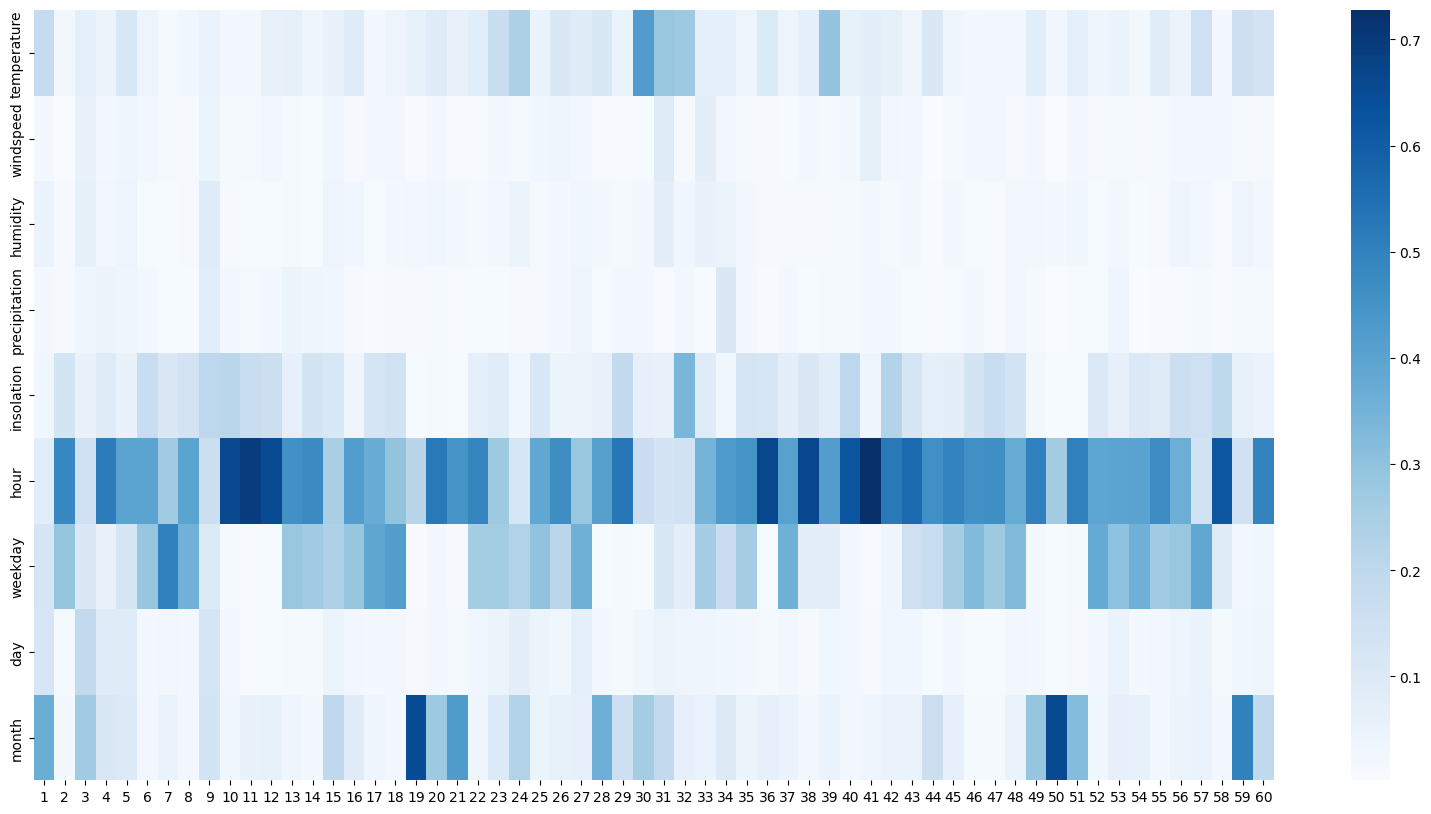

In [57]:
# 건물별 Feature Importance
i_dict = {i:models[i].feature_importances_ for i in range(1,61)}
i_df = pd.DataFrame(i_dict).transpose()
i_df.columns = x_train.columns

fig = plt.figure(figsize = (20, 10))
sns.heatmap(i_df.T, cmap = 'Blues')